# **CIS 5450 Final Project - Online Retail Customer Segmentation and Forecasting**
*Tongxun Hu, Liuyao Zhang, Tingyu Lu*

## 1. Introduction

E-commerce has become a central part of modern retail, and the large amount of data generated by online transactions allows businesses to study customer behavior with much greater detail than before. Transaction level data makes it possible to examine purchasing habits, observe temporal patterns in demand, and identify operational problems such as order cancellations. Since a cancelled order represents lost revenue and additional cost for the retailer, understanding the conditions under which cancellations occur is an important practical problem.

In this project, we analyze the Online Retail Dataset from the UCI Machine Learning Repository. It contains more than half a million invoice line records from a United Kingdom based online retailer during the period from December 2010 to December 2011. Each record includes information on the product purchased, the quantity, the unit price, the invoice identifier and timestamp, the customer identifier, and the customer country. The dataset also records cancellation events, which allows us to study both regular purchases and cancelled transactions.

Our goal is to investigate the behavioral, temporal, product related, and customer related patterns that are associated with cancelled orders. The dataset supports this analysis because it contains both item level and customer level information. We can therefore explore questions that involve product mix, purchasing frequency, seasonal demand, and differences across customer groups. Based on these patterns, we then examine whether we can build models that use transactional features to predict whether an order is likely to be cancelled.

This notebook begins with data cleaning and the construction of variables that are suitable for invoice level and customer level analysis. We then conduct exploratory analysis to study overall sales patterns and cancellation behavior. Each part of the analysis is motivated by the potential value of the information for later feature design. Finally, we build predictive models to assess how well cancellation risk can be estimated using the features derived from the data.

The purpose of this project is to provide a careful and data driven study of cancellation behavior in an online retail setting, and to evaluate how much predictive value can be extracted from historical transaction data.

---

## 2. Data Loading & Inspection

This section outlines how we load the Online Retail dataset and examine its raw structure before performing any cleaning. Since our goal is to study cancellation behavior and construct a model that predicts whether an order will be cancelled, we begin by inspecting the data carefully and identifying patterns that may affect the reliability of later features. The preprocessing choices in this phase determine what information is preserved, what is removed, and how the dataset is shaped for all downstream analysis.

### 2.1 Loading the Dataset

We retrieve the Online Retail dataset (UCI ID 352) using the ucimlrepo package. The dataset contains more than half a million invoice line records from a UK based online retailer, covering December 2010 through December 2011. To ensure that our workflow is reproducible, we rely on the version stored in the repository rather than any local copies.

In [1]:
# Imports + Installs
!pip install ucimlrepo


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


In [3]:
online_retail = fetch_ucirepo(id=352)
df = online_retail.data.original  # full dataset as provided
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


The dataset consists of the following fields:

* **InvoiceNo**: identifier for each transaction. Invoices that begin with the letter C represent cancellation records.
* **StockCode**: unique product code
* **Description**: product name
* **Quantity**: number of units purchased
* **InvoiceDate**: timestamp of the transaction
* **UnitPrice**: price of one unit
* **CustomerID**: unique customer identifier
* **Country**: country where the customer is located

This structure allows analysis at both the invoice level and the customer level, which is essential for predicting cancellation events.

### 2.2 Initial Inspection

Before cleaning the dataset, we first review its structure and content. This step helps us understand what irregularities exist, what information is missing, and which variables require special attention.

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe(include="all")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

The inspection highlights several points that will shape our cleaning decisions:
1. CustomerID has substantial missingness. Since many of our planned features depend on customer level history, we will need to decide how to handle rows without a valid identifier.
2. Description has a smaller number of missing values, which may relate to incomplete product metadata rather than errors.
3. Quantity ranges from large positive values to very large negative values.
4. UnitPrice includes negative entries.
5. Both Quantity and UnitPrice are highly skewed, suggesting that they may encode returns, bulk orders, or data issues.

Since cancellation is our predicted variable, these irregularities are not necessarily noise. We therefore investigate them more carefully before deciding which values to keep and which to correct.

### 2.3 Understanding Negative Quantity and Negative UnitPrice
Negative values in transactional data can arise for different reasons. Some represent legitimate business activity, while others are likely recording errors. Distinguishing between the two is important, because removing meaningful information would weaken our model, while keeping inconsistent data can introduce bias.
To guide our cleaning decisions, we examine how negative quantities and negative prices relate to cancellation invoices.

Step 1: Identify Cancellation Rows

Invoices beginning with the letter C represent cancellation or reversal activity.
We create a flag so that we can compare negative values across cancelled and non cancelled transactions.

In [7]:
df["is_cancel"] = df["InvoiceNo"].astype(str).str.startswith("C")

Step 2: Examine Negative Quantity

Negative Quantity usually indicates that a previous sale was reversed.
To confirm this, we check how these rows are distributed across cancelled and non cancelled invoices.

In [8]:
neg_qty = df[df["Quantity"] < 0]

print("Number of rows with negative Quantity:", len(neg_qty))
print("\nNegative Quantity by cancellation status (count):")
print(neg_qty["is_cancel"].value_counts(dropna=False))

print("\nNegative Quantity by cancellation status (proportion):")
print(neg_qty["is_cancel"].value_counts(normalize=True, dropna=False))


Number of rows with negative Quantity: 10624

Negative Quantity by cancellation status (count):
is_cancel
True     9288
False    1336
Name: count, dtype: int64

Negative Quantity by cancellation status (proportion):
is_cancel
True     0.874247
False    0.125753
Name: proportion, dtype: float64


Results
- Total rows with negative Quantity: 10,624
- About 87.4 percent appear in cancellation invoices.
- About 12.6 percent do not appear in cancellation invoices.

This pattern suggests that negative quantities are mostly associated with cancellation activity, but not exclusively. The remaining cases may represent manual adjustments, partial returns, or inconsistent accounting practices. These observations will help us determine whether to keep negative quantities as meaningful signals or treat some of them separately during cleaning.   

Step 3: Examine Negative UnitPrice

Negative UnitPrice is uncommon in retail data and usually reflects an entry error or a special adjustment.

In [9]:
neg_price = df[df["UnitPrice"] < 0]

print("\nNumber of rows with negative UnitPrice:", len(neg_price))
print("\nNegative UnitPrice by cancellation status (count):")
print(neg_price["is_cancel"].value_counts(dropna=False))

print("\nNegative UnitPrice by cancellation status (proportion):")
print(neg_price["is_cancel"].value_counts(normalize=True, dropna=False))


Number of rows with negative UnitPrice: 2

Negative UnitPrice by cancellation status (count):
is_cancel
False    2
Name: count, dtype: int64

Negative UnitPrice by cancellation status (proportion):
is_cancel
False    1.0
Name: proportion, dtype: float64


- Only 2 rows contain negative UnitPrice.
- Neither of them belongs to a cancellation invoice.

This suggests that these entries are unlikely to represent meaningful business activity. They are candidates for removal or correction in the cleaning stage.

We want to comfirm that whether all cancelled invoices contain at least one negative quantity line.

In [10]:
# All cancelled invoices
cancel_df = df[df["is_cancel"] == True]

# Cancelled invoices where ALL quantities are positive
cancel_pos_only = cancel_df[cancel_df["Quantity"] > 0]

# Cancelled invoices where at least one negative quantity appears
cancel_mixed = cancel_df[cancel_df["Quantity"] < 0]

print("Total cancelled invoices:", cancel_df["InvoiceNo"].nunique())
print("Invoices with at least one negative quantity:", cancel_mixed["InvoiceNo"].nunique())
print("Invoices with only positive quantities:", cancel_pos_only["InvoiceNo"].nunique())

Total cancelled invoices: 3836
Invoices with at least one negative quantity: 3836
Invoices with only positive quantities: 0


This means:
- Every invoice starting with "C" includes a negative Quantity somewhere inside it.
- The dataset is internally consistent for cancellation representation.
- There are no cancellation invoices that contain only positive quantities.

Summary of Findings
This exploratory inspection provides evidence for the decisions we will make during cleaning:

Negative Quantity
1. Mostly appears in cancelled invoices and therefore contains useful information for defining cancellation behavior.
2. Should generally be kept, because removing them may cause the model to miss important patterns.
3. All cancelled invoices contain at least one negative quantity line.

Negative UnitPrice
1. Extremely rare and unrelated to cancellations.
2. Likely to be data entry errors and will be corrected or removed.

These observations guide the decisions we implement in the next section, where we clean the dataset and construct the structure needed for modeling.

---

## 3. Data Cleaning and Preprocessing

The goal of our cleaning process is to prepare a dataset that preserves information relevant to cancellation behavior while removing records that cannot contribute meaningful features. Since our analysis and modeling will operate at the invoice level and the customer level, we focus on ensuring that each transaction can be linked to a customer, belongs to a well defined invoice, and contains valid monetary and temporal information.

#### 3.1 Handling missing identifiers and product information

1. Remove rows without a valid CustomerID.

Customer level features, such as past purchases, frequency, and previous cancellations, require a consistent customer identifier. Rows without a CustomerID cannot be assigned to any customer history and therefore cannot contribute to customer based feature construction. These rows are removed.

In [11]:
df_clean = df.copy()
df_clean = df_clean.dropna(subset=["CustomerID"])

2. Keep rows with missing product descriptions

A small fraction of rows lack a product description. Because our prediction task does not involve text based product features, the presence of a missing description does not affect invoice level aggregation or customer level history. We retain these rows rather than removing usable transaction data.

#### 3.2 Standardizing data types
1. Convert InvoiceDate to a datetime object.

Accurate time based analysis requires treating invoice timestamps as datetime objects. This also allows extraction of daily and monthly indicators used in temporal feature construction.

2. Convert CustomerID to integer.

The raw data stores CustomerID as a float. We convert it to numeric, drop any remaining non numeric entries, and cast the field to integer to ensure stable grouping operations.

In [12]:
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"])
df_clean["CustomerID"] = pd.to_numeric(df_clean["CustomerID"], errors="coerce")
df_clean = df_clean.dropna(subset=["CustomerID"])
df_clean["CustomerID"] = df_clean["CustomerID"].astype(int)

#### 3.3 Preserving cancellations and handling negative values

The inspection shows that invoices beginning with the letter C correspond to cancelled orders, and every cancelled invoice contains at least one line with a negative quantity. Negative quantities also appear outside cancelled invoices, but their interpretation is not explicit from the dataset documentation. Since these values reflect some form of adjustment recorded at the transaction level, and since they occur consistently in the raw data, we keep them rather than removing information whose meaning is not fully known.

Negative unit prices, in contrast, are extremely rare and do not appear in cancelled invoices. Because these cases are not supported by the dataset documentation and do not follow any clear transaction pattern, we treat them as invalid entries.

These observations motivate the following steps:
1. Retain cancellation rows

Cancelled invoices contain the outcome we aim to predict. All rows belonging to invoices whose identifier begins with C are kept, and the cancellation label will be derived directly from the invoice number.

2. Keep negative quantities

Negative quantities appear systematically in cancelled invoices and also in a smaller number of other transactions. Because they may represent valid adjustments and because they carry information about the flow of goods, we keep them in the cleaned dataset.

3. Remove rows with invalid prices or zero values

Rows with negative unit prices are extremely rare and lack a clear interpretation, so they are removed. Rows with zero quantity or zero price do not correspond to meaningful purchases and are also excluded to avoid distortions in monetary calculations.

In [13]:
# Remove invalid unit prices (negative or zero)
df_clean = df_clean[df_clean["UnitPrice"] > 0]

# Remove zero quantities
df_clean = df_clean[df_clean["Quantity"] != 0]

#### 3.4 Derived monetary and temporal features
To prepare the dataset for invoice level analysis and modeling, we create derived variables that summarize the economic and temporal characteristics of each transaction.

1. TotalPrice

TotalPrice = Quantity * UnitPrice captures the line level value of each transaction. For cancellation lines this value is negative, which preserves the direction of monetary flow.

2. Calendar based features

We extract the calendar date and the month period from the timestamp. These variables are used to study seasonal patterns and construct time based features.

In [14]:
df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["UnitPrice"]
df_clean["InvoiceDateOnly"] = df_clean["InvoiceDate"].dt.date
df_clean["InvoiceMonth"] = df_clean["InvoiceDate"].dt.to_period("M")

3.5 Resulting dataset
After the cleaning process:
- All rows have valid customer identifiers
- All cancellation information is preserved
- Negative quantities remain as meaningful transaction signals
- Rare invalid unit prices and zero value rows are removed
- Temporal and monetary features are ready for invoice level aggregation

This cleaned dataset provides a consistent and informative basis for exploratory analysis and for building predictive models of cancellation behavior.

---

## 4. Exploratory Data Analysis (EDA)

In this section we study the cleaned transaction data from several angles that are directly related to cancellation prediction. We start from the outcome distribution at the invoice level, then examine patterns at the item level and the customer level, and finally consider temporal and geographic variation. For each view, we focus on how the patterns may inform feature construction and model design.

Throughout this section, we use df_clean, which contains only rows with valid customer identifiers, positive unit prices, and non zero quantities, and retains all cancellation activity and negative quantities.

### 4.1 Cancellation outcome at the invoice level

Our prediction target is whether an order, understood as an invoice, is cancelled. The raw dataset contains 541,909 transaction lines and 25,900 unique invoices. Among these, 3,836 invoices have identifiers beginning with the letter C and are therefore labelled as cancelled. Cancellations are a minority outcome at the invoice level, which implies that our prediction problem is imbalanced.

To work at the invoice level, we summarise the cleaned data by InvoiceNo and define a binary outcome for each invoice.

In [15]:
invoice_df = (
    df_clean
    .groupby("InvoiceNo")
    .agg(
        is_cancel=("is_cancel", "max"),          # invoice is cancelled if any line is marked as cancelled
        customer_id=("CustomerID", "first"),
        country=("Country", "first"),
        invoice_date=("InvoiceDate", "first"),
        n_lines=("Quantity", "size"),
        total_quantity=("Quantity", "sum"),
        total_value=("TotalPrice", "sum")
    )
    .reset_index()
)

invoice_cancel_rate = invoice_df["is_cancel"].mean()
invoice_cancel_rate

0.16469845848733436

This aggregation serves two purposes. First, it creates the modeling table with one row per invoice, which matches our prediction target. Second, it provides basic invoice level variables, such as order size and total value, which we expect to be related to cancellation behavior.

The relatively low cancellation rate suggests that simple accuracy would not be an informative evaluation metric, and that we should pay closer attention to recall, precision, and class specific performance when assessing models.

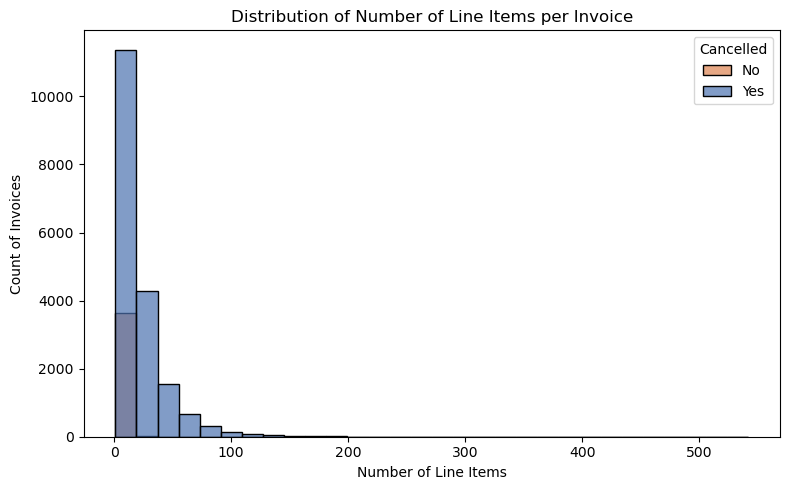

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute number of line items per invoice

plt.figure(figsize=(8, 5))
sns.histplot(
    data=invoice_df,
    x="n_lines",
    hue="is_cancel",
    bins=30,
    kde=False,
    palette=["#4C72B0", "#DD8452"],
    alpha=0.7
)

plt.title("Distribution of Number of Line Items per Invoice")
plt.xlabel("Number of Line Items")
plt.ylabel("Count of Invoices")
plt.legend(title="Cancelled", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

Key observations:

- Most invoices are small, with fewer than ~20 line items, but there is a
  long tail of very complex orders.
- Cancelled invoices appear more frequently in the right tail of the
  distribution, suggesting that **more complex orders are more likely to be
  cancelled**.
- This motivates the use of `n_lines` and large‐order indicators as key
  predictive features in later modeling.


#### 4.2 Item level structure and price quantity distributions
At the item level, each row in df_clean represents a single product line within an invoice. Studying the distributions of quantity and price at this level helps us understand the heterogeneity of orders and identify transformations that make these variables more suitable for modeling.


#### 4.2.1 Quantity and unit price distributions
We first examine the marginal distributions of Quantity and UnitPrice in the cleaned data.

In [17]:
df_clean[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406789.000000,406789.000000
mean,12.028359,3.460811
std,247.927842,69.318561
min,-80995.000000,0.001000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Several patterns are noteworthy:
1. Heavy right skew

For both variables, the mean is far above the median. A small number of transactions involve very large quantities or very expensive items, creating heavy right tails.

2. Presence of large negative quantities

Negative quantities arise from cancellation records, where returned items are recorded as negative units. These values are part of the underlying business process rather than errors, so they are preserved.

3. Wide range of unit prices

Most products are inexpensive, yet a few items carry very high prices. This long-tail price distribution is typical for retail data but indicates that raw price values should not be used directly as model predictors.

These observations motivate several design choices for feature engineering:
- summarizing quantities at the invoice level (e.g., total quantity, average quantity)
- using absolute or log-transformed quantities when necessary
- treating unit price through aggregates (mean, median, high-price indicator) rather than raw values
- avoiding raw item-level values as inputs to the model due to extreme scale differences

#### 4.2.2 Relationship between quantity and cancellation

Because cancelled invoices contain negative quantities on their lines, while regular invoices contain positive quantities, the sign of Quantity at the item level is closely tied to the cancellation mechanism. To avoid defining the label through a variable that we later use as a predictor, we keep the cancellation flag at the invoice level and treat the sign of quantity at the item level as descriptive rather than as a stand alone predictor.
However, the magnitude of quantities may still be informative. We can explore whether very large orders tend to be associated with cancellations more often than smaller orders by comparing the distribution of absolute quantities between cancelled and non cancelled invoices.

In [18]:
df_clean["abs_quantity"] = df_clean["Quantity"].abs()

line_stats = (
    df_clean
    .groupby("is_cancel")["abs_quantity"]
    .describe()
)

line_stats

,count,mean,std,min,25%,50%,75%,max
is_cancel,,,,,,,,
False,397884.0,12.988238,179.331775,1.0,2.0,6.0,12.0,80995.0
True,8905.0,30.859966,1170.154939,1.0,1.0,2.0,6.0,80995.0


Key observations:
- Cancelled lines have a much higher **mean** (30.9 vs 13.0), driven by a
  small number of extremely large cancellations.
- The **median** quantity is actually smaller for cancelled lines (2 vs 6),
  showing that typical cancelled items involve **small quantities**, and the
  relationship between order size and cancellation is mostly driven by the
  extreme tail.
- Variance is substantially higher for cancelled lines, indicating that a minority of cancellations involve very large orders.

Implications for modeling:
- Order size appears related to cancellation behaviour, but the relationship is driven by the tail rather than typical quantities.
- Features such as total quantity, maximum line quantity, log-transformed quantity, or indicators for unusually large orders may help capture this pattern at the invoice level.

#### 4.2.3 Product level frequency and cancellation share

To understand whether certain products are more prone to cancellation than others, we look at product codes (StockCode) and count how often each product appears in cancelled and non cancelled invoices.

In [19]:
product_summary = (
    df_clean
    .assign(is_cancel_invoice=df_clean["is_cancel"])
    .groupby("StockCode")
    .agg(
        total_lines=("Quantity", "size"),
        lines_in_cancel=("is_cancel_invoice", "sum")
    )
    .assign(cancel_share=lambda x: x["lines_in_cancel"] / x["total_lines"])
    .sort_values("total_lines", ascending=False)
)

product_summary.head()

,total_lines,lines_in_cancel,cancel_share
StockCode,,,
85123A,2077,42,0.020221
22423,1904,181,0.095063
85099B,1662,44,0.026474
84879,1418,10,0.007052
47566,1415,19,0.013428


Key observations:
- High-frequency products generally show low cancellation shares (often 1–3%).

This suggests that commonly purchased items are rarely cancelled and may represent stable, low-risk inventory.
- Some products show noticeably higher cancellation shares, such as StockCode 22423 (9.5%).

These products may reflect niche demand, supply uncertainty, or seasonal patterns.
- Cancellation behaviour is not uniform across products, indicating that product mix may affect the likelihood that an invoice gets cancelled.

Implications for modeling:
- Because there are thousands of distinct products, individual StockCode identifiers are too granular for direct use as model features.
- However, product-level patterns suggest useful higher-level features at the invoice level, such as:

1. number or proportion of “high-cancellation-share” products in an order
2. presence of top-selling products
3. indicators for unusual or rare products
4. invoice-level summary statistics of price or quantity by product type

These aggregated features can capture product-related cancellation risk without introducing a huge number of sparse categorical variables.

### 4.3 Temporal patterns in orders and cancellations
Time is a natural dimension in online retail. Demand, stock levels, and operational pressure vary across days, weeks, and months. These factors can in turn affect cancellation probabilities.

#### 4.3.1 Monthly order volume and cancellation rate
Using InvoiceMonth, we examine how total order volume and cancellation rate vary over time.

In [20]:
invoice_df["InvoiceMonth"] = invoice_df["invoice_date"].dt.to_period("M")

month_summary = (
    invoice_df
    .groupby("InvoiceMonth")
    .agg(
        n_invoices=("InvoiceNo", "size"),
        n_cancel=("is_cancel", "sum")
    )
    .assign(cancel_rate=lambda x: x["n_cancel"] / x["n_invoices"])
    .reset_index()
)

month_summary.head()

,InvoiceMonth,n_invoices,n_cancel,cancel_rate
0,2010-12,1708,308,0.180328
1,2011-01,1236,249,0.201456
2,2011-02,1201,204,0.169858
3,2011-03,1619,298,0.184064
4,2011-04,1384,235,0.169798


Key observations:
- Cancellation rates remain relatively stable across months, generally between 17% and 20%.
This consistency suggests that cancellations are not dominated by a single season or event.
- Order volume fluctuates, with December and March showing higher activity.
These patterns reflect typical retail seasonality.
- Although cancellation rates do not exhibit large swings, months with higher activity also tend to have more cancellations in absolute terms, which is expected because cancellations scale with total invoice count.

Implications for modeling:
- Monthly indicators may still be useful since cycle effects and operational load can subtly affect cancellation likelihood.
- Temporal features such as month, quarter, or season can help the model capture systematic time patterns even if the cancellation rate is relatively stable.

#### 4.3.2 Day of week and time of day
We can also decompose InvoiceDate into day of week and hour of day to check whether orders placed at particular times behave differently.

In [21]:
invoice_df["weekday"] = invoice_df["invoice_date"].dt.weekday  # 0 = Monday
invoice_df["hour"] = invoice_df["invoice_date"].dt.hour

weekday_summary = (
    invoice_df
    .groupby("weekday")
    .agg(
        n_invoices=("InvoiceNo", "size"),
        n_cancel=("is_cancel", "sum")
    )
    .assign(cancel_rate=lambda x: x["n_cancel"] / x["n_invoices"])
    .reset_index()
)
weekday_summary

,weekday,n_invoices,n_cancel,cancel_rate
0,0,3512,649,0.184795
1,1,3891,707,0.181701
2,2,4110,655,0.159367
3,3,4977,945,0.189873
4,4,3354,525,0.156530
5,6,2342,173,0.073868


/var/folders/0v/gt2d2zfs0g91_hf0p5jsr5w00000gn/T/ipykernel_69058/583331031.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


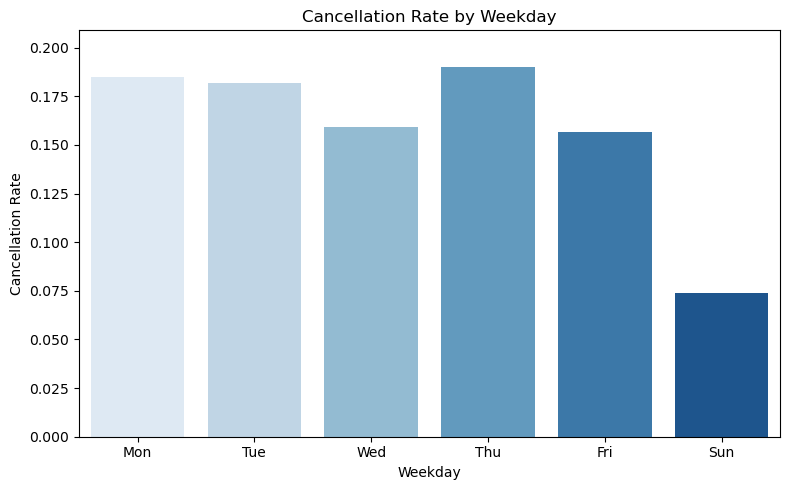

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

weekday_map = {
    0: "Mon",
    1: "Tue",
    2: "Wed",
    3: "Thu",
    4: "Fri",
    5: "Sat",
    6: "Sun"
}

weekday_summary["weekday_label"] = weekday_summary["weekday"].map(weekday_map)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=weekday_summary,
    x="weekday_label",
    y="cancel_rate",
    palette=sns.color_palette("Blues", len(weekday_summary))
)

plt.title("Cancellation Rate by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Cancellation Rate")
plt.ylim(0, weekday_summary["cancel_rate"].max() * 1.1)
plt.tight_layout()
plt.show()


The dataset contains no transactions labeled with weekday = 5, which corresponds to Saturday.

Key observations:
- Weekday cancellation rates cluster between 15%–19%, showing a fairly stable pattern during business days.
- Thursdays and Mondays show slightly higher cancellation rates (~19%), which may reflect restocking cycles or end/start-of-week processing behaviour.
- Sundays show a much lower cancellation rate (~7%), likely due to lower overall activity and limited operational processing on weekends.

Implications for modeling:
- Weekday appears to be a meaningful but moderate temporal signal.
- Including day-of-week indicators may help capture subtle patterns in operational behaviour.
- Lower activity and lower cancellation probability on weekends suggest that temporal cycles should be considered in invoice-level features.

In [23]:
hour_summary = (
    invoice_df
    .groupby("hour")
    .agg(
        n_invoices=("InvoiceNo", "size"),
        n_cancel=("is_cancel", "sum")
    )
    .assign(cancel_rate=lambda x: x["n_cancel"] / x["n_invoices"])
    .reset_index()
)
hour_summary

,hour,n_invoices,n_cancel,cancel_rate
0,6,22,21,0.954545
1,7,31,2,0.064516
2,8,608,53,0.087171
3,9,1621,228,0.140654
4,10,2613,387,0.148106
5,11,2770,493,0.177978
6,12,3596,467,0.129867
7,13,3042,406,0.133465
8,14,2644,370,0.139939
9,15,2404,367,0.152662


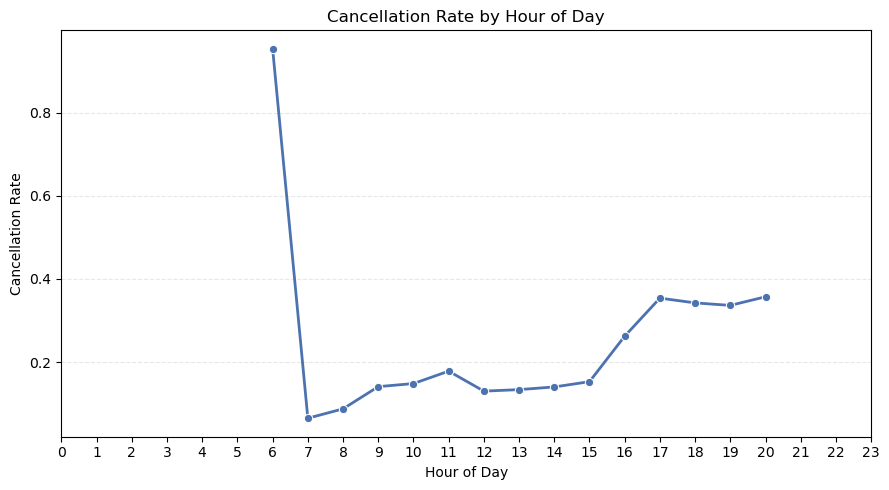

In [24]:
plt.figure(figsize=(9, 5))
sns.lineplot(
    data=hour_summary,
    x="hour",
    y="cancel_rate",
    marker="o",
    linewidth=2,
    color="#4C72B0"
)

plt.title("Cancellation Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Cancellation Rate")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Key observations:
- Regular daytime hours (8:00–15:00) show stable cancellation rates between 13%–18%, consistent with weekday-level patterns.
- Late afternoon and evening hours (16:00–20:00) show substantially higher cancellation rates, rising above 25%, although overall invoice volume declines in these hours.
 Very early hours (06:00–07:00) exhibit extreme cancellation rates, but the number of invoices is very small. These values likely reflect low-volume operational artefacts rather than genuine behavioural differences.

Implications for modeling:
- Hour of day carries meaningful structure and may help capture operational or workflow-related patterns.
- Because some hours have low volume, hour-based features may require binning (e.g., morning / midday / afternoon / evening) to avoid noise.
- The distinction between high-activity hours and high-cancellation hours suggests temporal predictors may improve model performance.

### 4.4 Customer-Level Behavior

So far, we have primarily examined cancellation patterns at the **invoice** (order) level and explored item-level and temporal structure.  
However, cancellations are also strongly driven by **who** the customer is:

- Some customers may be highly engaged and rarely cancel.
- Others may place only a few orders, with a higher proportion cancelled.
- Long-standing customers might behave differently from new/one-off customers.

In this section, we move to the **customer level**, aggregating multiple invoices per customer to study:
1. How large and diverse our customer base is.
2. How customer spending is distributed.
3. How cancellation propensity varies by customer.

These patterns will guide the construction of **customer history features** (e.g., past cancellation rate, total spend, tenure), which can be very powerful predictors when we later try to forecast whether a *future* invoice will be cancelled.


#### 4.4.1 Geographical Analysis

We first look at  how customers are distributed across countries.

This is important because:
- It reveals whether cancellation patterns might be driven by a few large markets (e.g., the UK) versus smaller international markets.
- It helps us decide whether to include **country-level features** in the model or treat some markets differently (for example, a dominant home market vs. “rest of world”).


In [25]:
# Customers by country
customers_by_country = (
    df_clean.groupby("Country")["CustomerID"]
    .nunique()
    .reset_index(name="n_customers")
    .sort_values("n_customers", ascending=False)
)

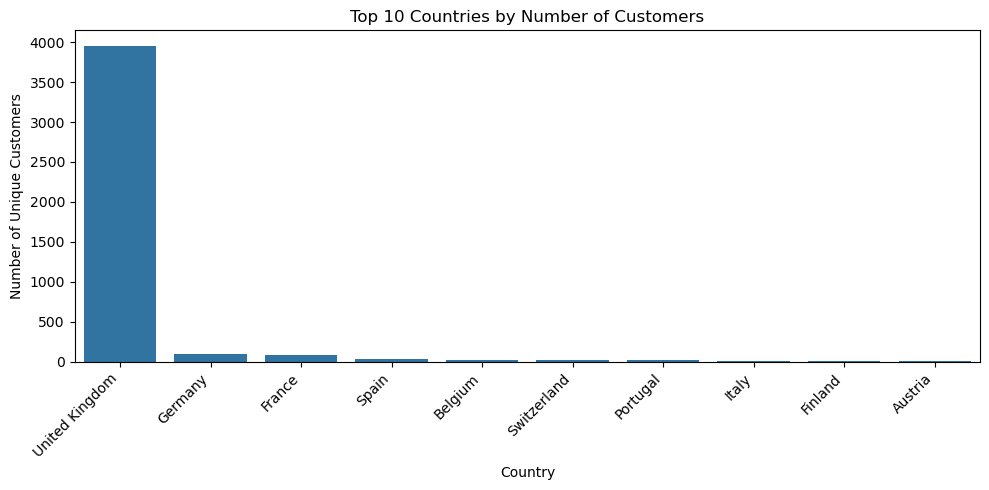

In [26]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=customers_by_country.head(10),
    x="Country",
    y="n_customers"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Unique Customers")
plt.title("Top 10 Countries by Number of Customers")
plt.tight_layout()
plt.show()


The dataset is dominated by the UK, with significantly fewer invoices from other countries. This imbalance makes raw country data unsuitable for direct modeling. If we one-hot encoded every country, we would create many sparse, unstable dummy variables.

In [27]:
cancel_rate_by_country = (
    invoice_df.groupby("country")["is_cancel"]
    .mean()
    .reset_index(name="cancel_rate")
    .sort_values("cancel_rate", ascending=False)
)


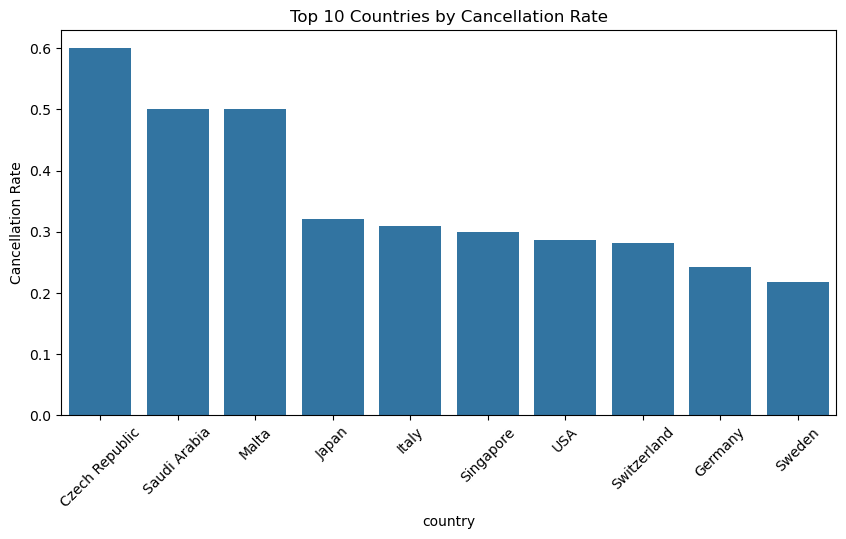

In [28]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=cancel_rate_by_country.head(10),
    x="country",
    y="cancel_rate"
)
plt.xticks(rotation=45)
plt.title("Top 10 Countries by Cancellation Rate")
plt.ylabel("Cancellation Rate")
plt.show()


This suggests that cancellation behavior may differ across countries, with the United Kingdom representing the majority of all invoices.
Before deciding how to incorporate geographical information into our predictive model, we formally test whether **UK** and **non-UK** invoices have statistically different cancellation rates.

Because the outcome (`is_cancel`) is binary and we are comparing proportions between two independent groups (UK vs. non-UK), we use a **two-proportion z-test**, the standard statistical test for differences in binary event rates.


#### **Hypotheses**

Let:

- $p_{\text{UK}}$ = cancellation rate for UK invoices  
- $p_{\text{nonUK}}$ = cancellation rate for non-UK invoices  

We test:

- **Null hypothesis (H₀):**  
   $p_{\text{UK}} = p_{\text{nonUK}}$
  (There is no difference in cancellation rate.)

- **Alternative hypothesis (H₁):**  
   $p_{\text{UK}} \neq p_{\text{nonUK}}$  
  (Cancellation rates differ between UK and non-UK countries.)

This is a two-sided test because we do not assume in advance which group has a
higher cancellation tendency.

In [29]:
from scipy.stats import norm
import numpy as np

uk = invoice_df[invoice_df["country"] == "United Kingdom"]
non_uk = invoice_df[invoice_df["country"] != "United Kingdom"]
x1 = uk["is_cancel"].sum()
x2 = non_uk["is_cancel"].sum()
n1 = len(uk)
n2 = len(non_uk)

p_pool = (x1 + x2) / (n1 + n2)
se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))

z_stat = (x1/n1 - x2/n2) - 0
z_stat /= se
p_value = 2 * (1 - norm.cdf(abs(z_stat)))

z_stat, p_value


(-3.6545858530403854, 0.00025759745575415494)

Using the two-proportion z-test, we statistically compared cancellation rates between UK and non-UK invoices. The resulting test statistic and p-value were:

- **z-statistic:** –3.65  
- **p-value:** 0.00026  

Because the p-value is far below the conventional 0.05 threshold, we **reject the null hypothesis** that UK and non-UK invoices have the same cancellation rate. This means the observed difference in cancellation behavior between UK and non-UK customers is **highly statistically significant** and very unlikely to be due to random chance.

In practical terms, this confirms:

- **Geography has a real, meaningful impact on cancellation behavior.**  
- The UK behaves differently from other countries with respect to cancellations.  
- It is appropriate — and necessary — to incorporate geographical information into our predictive model.

However, because the dataset is extremely geographically imbalanced (with the UK representing the overwhelming majority of invoices), we cannot use raw country categories directly. Instead, in Section 5 we adopt a more stable and statistically justified approach:

1. **Group high-volume countries** into distinct categories while collapsing all other countries into an “Other” class, and  
2. Add a **numeric feature representing each country’s historical cancellation rate** (target encoding).  

This combination allows the model to leverage geographical signal without introducing sparsity or overfitting.

#### 4.4.2 Distribution of Customer Spending

Next, we examine how much each customer spends overall.

We compute a simple measure:
- **Total spending per customer** = sum of line-level `TotalPrice` over all their transactions (including both regular and cancellation-related entries).

This matters for prediction because:
- High-value customers might be treated differently from low-value customers (e.g., lenient policies, different ordering patterns).
- There is often a **long-tail distribution** where a small fraction of customers accounts for a large share of revenue.
- Understanding this shape helps us decide whether to transform monetary features (e.g., log-scale) before modeling.


In [30]:
# Total spending per customer (including all transactions)
customer_spend = (
    df_clean.groupby("CustomerID")["TotalPrice"]
    .sum()
)

customer_spend.describe()


count      4371.000000
mean       1898.894032
std        8220.235339
min       -4287.630000
25%         293.785000
50%         648.410000
75%        1611.860000
max      279489.020000
Name: TotalPrice, dtype: float64

The descriptive statistics above summarise the distribution of **total monetary value per customer**:

- A low median but a much higher mean indicates a **right-skewed** distribution.
- A large gap between the 75th percentile and the maximum suggests that a few customers spend much more than the typical customer.

To better understand this skew, we visualize the distribution.

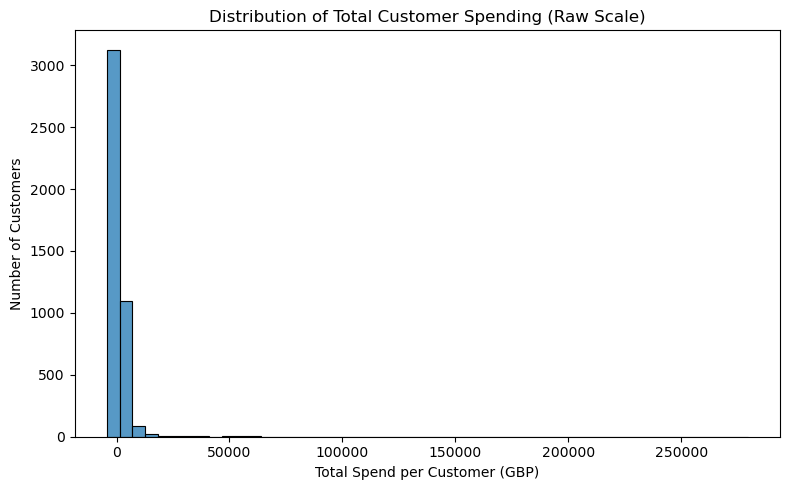

In [31]:
plt.figure(figsize=(8, 5))
sns.histplot(customer_spend, bins=50)
plt.xlabel("Total Spend per Customer (GBP)")
plt.ylabel("Number of Customers")
plt.title("Distribution of Total Customer Spending (Raw Scale)")
plt.tight_layout()
plt.show()


**What this plot shows**

- Most customers cluster at relatively low total spending.
- A long tail extends to much higher spending values, which are not very visible on the raw scale.

From a modeling perspective:
- Using raw spending values as features may give **disproportionate influence** to a few large customers.
- It may be more informative to:
  - Use **log-transformed spending**,
  - Or **bin** customers into spending tiers (e.g., low/medium/high).

We therefore also look at spending on a log scale (adding a small constant to avoid log(0)).

/Users/sherry/miniconda3/envs/earnings_transcript_scraping/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


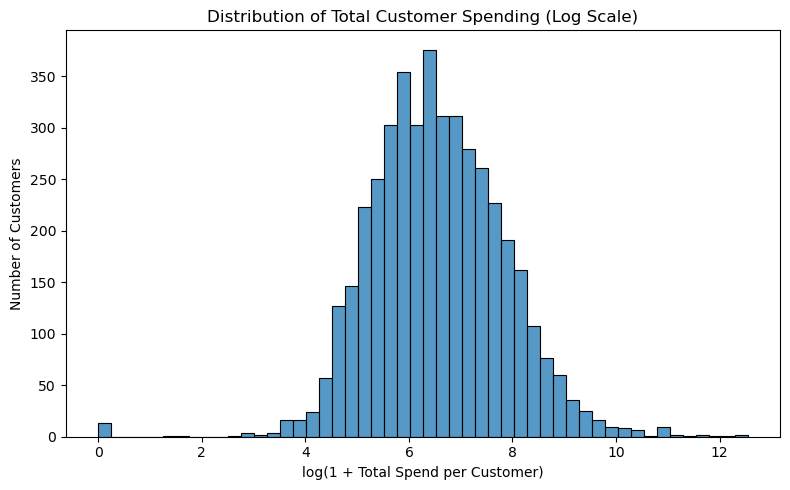

In [32]:
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(customer_spend), bins=50)
plt.xlabel("log(1 + Total Spend per Customer)")
plt.ylabel("Number of Customers")
plt.title("Distribution of Total Customer Spending (Log Scale)")
plt.tight_layout()
plt.show()


**Interpretation**

- On the log scale, the distribution becomes more spread out and informative.
- We can see more clearly how many customers are “low spenders” vs “medium” vs “high”.

This supports using a **log-transformed spending feature** or creating **spending bands** for our predictive model.  

Next, we add another key dimension: how often customers place orders and how often those orders are cancelled.


#### 4.4.3 Purchase Frequency and Cancellation Propensity

While total spending is important, **behavioral intensity** (how often a customer orders) and **cancellation propensity** (how often those orders are cancelled) are directly relevant to our prediction task.

We aggregate to the customer level using the invoice-level table `invoice_df`:

For each customer, we compute:
- `n_invoices`: number of distinct invoices
- `n_cancel`: number of cancelled invoices
- `cancel_rate`: fraction of invoices that are cancelled
- `total_invoice_value`: total value across all invoices
- `avg_invoice_value`: average order value

These features later become **customer history predictors** for invoice-level cancellation.


In [33]:
# Customer-level summary from invoice_view
customer_behavior = (
    invoice_df
    .groupby("customer_id")
    .agg(
        n_invoices=("InvoiceNo", "nunique"),
        n_cancel=("is_cancel", "sum"),
        cancel_rate=("is_cancel", "mean"),
        total_invoice_value=("total_value", "sum"),
        avg_invoice_value=("total_value", "mean")
    )
    .reset_index()
)

customer_behavior.head()


,customer_id,n_invoices,n_cancel,cancel_rate,total_invoice_value,avg_invoice_value
0,12346,2,1,0.5,0.00,0.000000
1,12347,7,0,0.0,4310.00,615.714286
2,12348,4,0,0.0,1797.24,449.310000
3,12349,1,0,0.0,1757.55,1757.550000
4,12350,1,0,0.0,334.40,334.400000


The table above shows a few examples of customers and their aggregate behavior.  

Before using these as features, we want to understand:
- How many invoices customers typically have.
- How cancellation rates are distributed across customers.

Both of these influence:
- How strong customer-level features will be (customers with 1–2 invoices have very noisy cancellation rates).
- Whether we might want to treat **very low-frequency customers** differently (e.g., using population averages for them).


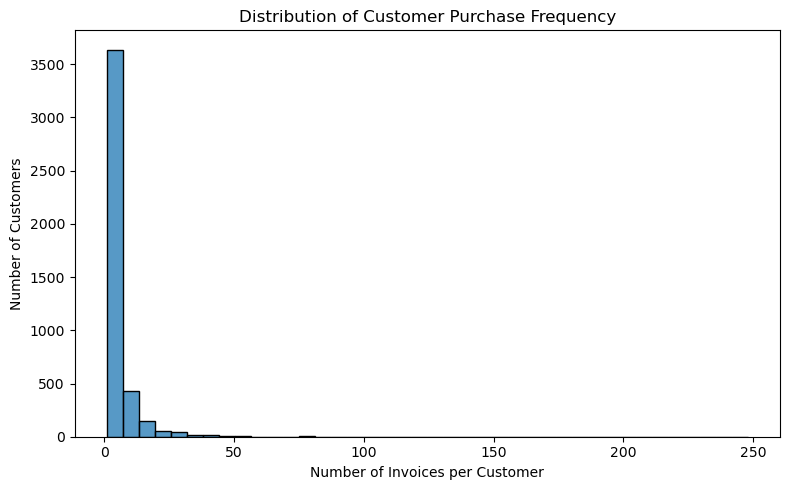

In [34]:
plt.figure(figsize=(8, 5))
sns.histplot(customer_behavior["n_invoices"], bins=40)
plt.xlabel("Number of Invoices per Customer")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customer Purchase Frequency")
plt.tight_layout()
plt.show()


- It shows whether our dataset mostly contains **one-off** customers versus **repeat** customers.
- If most customers have only 1–2 invoices, then:
  - Customer-level features based on history may be limited for many observations.
  - The model may need to rely more heavily on **invoice-level** and **product/time features**.
- If many customers have multiple invoices, then:
  - We can rely more on historical behavior such as past cancellation rate.

Now we inspect how **cancellation rates** vary across customers.


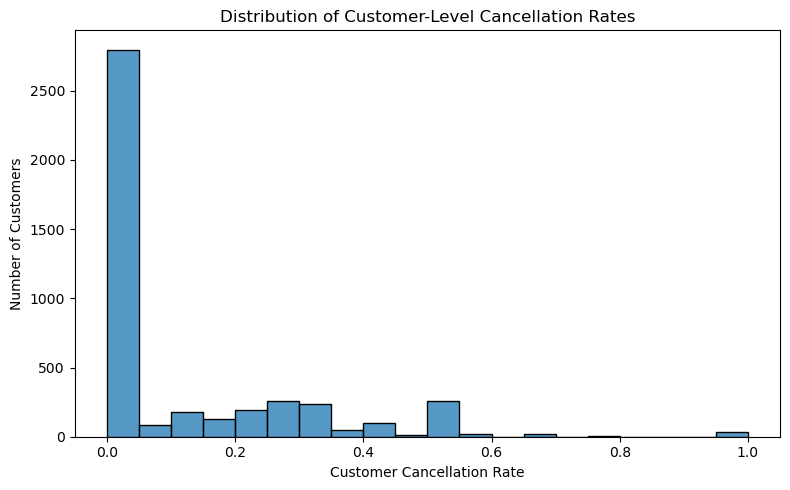

In [35]:
plt.figure(figsize=(8, 5))
sns.histplot(customer_behavior["cancel_rate"], bins=20)
plt.xlabel("Customer Cancellation Rate")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customer-Level Cancellation Rates")
plt.tight_layout()
plt.show()


**Interpretation**

- Many customers are likely to have a **cancellation rate of 0** (never cancelled in the observed period).
- Some customers show **non-zero** cancellation rates, with a few possibly cancelling a large fraction of their orders.

For modeling, this implies:
- A customer’s **past cancellation rate** could be a strong predictor of whether a future invoice will be cancelled.
- However, for customers with very few invoices, this rate is noisy; we may want to:
  - Combine it with `n_invoices` (e.g., weight by experience),
  - Or shrink extreme rates toward the overall average.


Finally, we examine how spending and cancellation propensity interact.
- By plotting **total spending** (x-axis, log scale) against **cancellation rate** (y-axis), we explore whether:
  - High-value customers tend to cancel less (perhaps due to better engagement),
  - Or whether cancellations are spread fairly uniformly across spending.

This relationship is important because:
- If high-spend customers rarely cancel, the model might assign lower cancellation risk to invoices from similar profiles.
- If there is no clear relationship, then spending features may contribute less to predicting cancellation, and other features (products, time, country) become more critical.

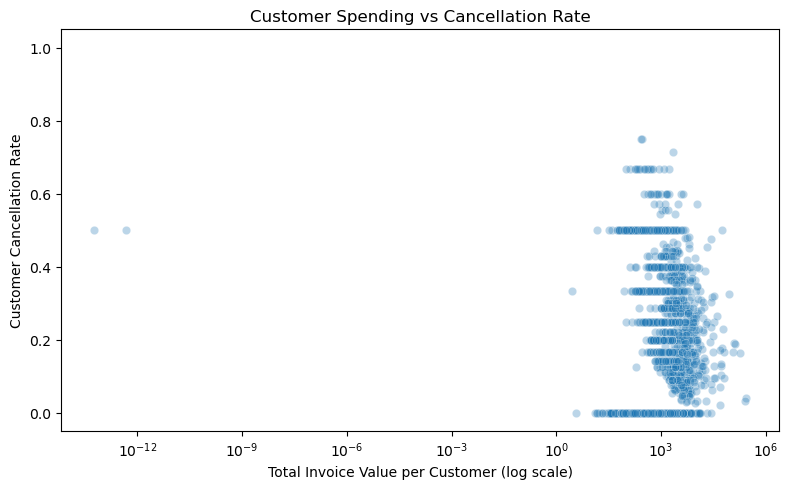

In [36]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=customer_behavior,
    x="total_invoice_value",
    y="cancel_rate",
    alpha=0.3
)
plt.xscale("log")
plt.xlabel("Total Invoice Value per Customer (log scale)")
plt.ylabel("Customer Cancellation Rate")
plt.title("Customer Spending vs Cancellation Rate")
plt.tight_layout()
plt.show()


The scatterplot above explores the relationship between a customer’s **total spending** (on a log scale) and their **overall cancellation rate**. Several important patterns emerge:

1. **Customer spending is extremely right-skewed.**  
   Even on a log scale, most customers cluster between approximately 10¹ and 10⁵ GBP in total spending, with only a few customers spending extremely small or extremely large amounts.  
   This confirms that monetary features should be **log-transformed** before modeling to reduce skew and avoid giving excessive influence to a small number of high-value customers.

2. **Low-spending customers exhibit very high variability in cancellation behavior.**  
   For customers with lower total spending, cancellation rates range widely—from 0 up to more than 0.6.  
   This indicates that spending alone does not explain cancellation behavior for low-value customers. These customers likely differ in important unobserved ways (e.g., number of invoices, tenure, purpose of purchase, country differences).

3. **High-spending customers tend to have lower and more stable cancellation rates.**  
   Customers who spend more overall show cancellation rates concentrated mostly between 0 and 0.3.  
   This suggests that high-value customers behave more consistently and may be more intentional or loyal purchasers (e.g., wholesale buyers or long-term clients).

4. **There is no simple linear relationship between spending and cancellation.**  
   Instead of a clear upward or downward trend, the pattern shows:
   - High variance in cancellation among low spenders  
   - Lower variance and fewer cancellations among high spenders  
   This reinforces that spending should not be used in isolation; instead, it should be combined with **behavioral features** such as number of past invoices, tenure, and historical cancellation rate.

**Modeling Implication:**  
Spending is a useful feature, but only when interpreted alongside the customer's purchase history. High spending may act as a weak negative predictor of cancellation risk, but the wide variability among low-spending customers means that spending alone is not a strong driver of cancellations. Therefore, features such as **customer tenure**, **invoice frequency**, and **past cancellation rate** will be essential for improving predictive power.



#### 4.4.4 Customer Tenure and Recency

A customer’s **tenure** (how long they have been active) can also affect cancellation behavior:
- New customers might experiment and cancel more.
- Long-term customers might have established habits and cancel less (or, in some cases, negotiate more returns).

We approximate tenure using the difference between the first and last observed transaction dates for each customer.


In [37]:
# Customer tenure based on first and last transaction dates
customer_dates = (
    df_clean
    .groupby("CustomerID")["InvoiceDate"]
    .agg(first_date="min", last_date="max")
    .reset_index()
)

customer_dates["tenure_days"] = (
    customer_dates["last_date"] - customer_dates["first_date"]
).dt.days

customer_dates.head()


,CustomerID,first_date,last_date,tenure_days
0,12346,2011-01-18 10:01:00,2011-01-18 10:17:00,0
1,12347,2010-12-07 14:57:00,2011-12-07 15:52:00,365
2,12348,2010-12-16 19:09:00,2011-09-25 13:13:00,282
3,12349,2011-11-21 09:51:00,2011-11-21 09:51:00,0
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,0


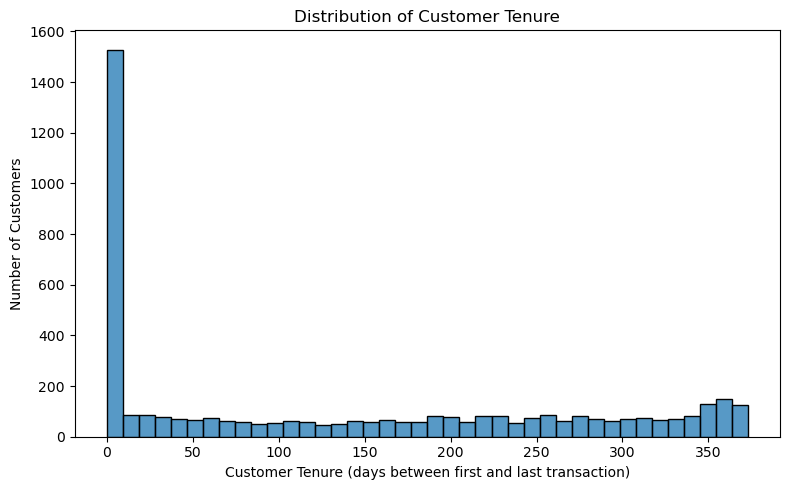

In [38]:
plt.figure(figsize=(8, 5))
sns.histplot(customer_dates["tenure_days"], bins=40)
plt.xlabel("Customer Tenure (days between first and last transaction)")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customer Tenure")
plt.tight_layout()
plt.show()


**Interpretation**

- Many customers may have **short observed tenure** (e.g., a single day), corresponding to one-off shoppers.
- Others have longer spans between their first and last observed purchase, suggesting **ongoing relationships**.

For modeling:
- We can include **tenure** as a feature to capture “maturity” of the relationship.
- Combining tenure with frequency (`n_invoices`) and cancellation rate produces a richer customer profile.



### 4.5 Summary of EDA and Implications for Modeling

Across item-level, invoice-level, temporal, and customer-level analyses, several consistent themes emerge:

1. **Class Imbalance**  
   - The proportion of cancelled invoices is relatively low.
   - Models must be evaluated using metrics that handle imbalance (e.g., ROC-AUC, PR-AUC, recall/precision on the cancelled class), not just raw accuracy.

2. **Heavy-Tailed Monetary Distributions**  
   - Both line-level and customer-level monetary values are highly skewed.
   - Log transformations or robust aggregation (e.g., medians, bins) are likely needed for stable modeling.

3. **Temporal and Operational Structure**  
   - Cancellation rates vary by **weekday** and **hour**, suggesting operational or workflow effects.
   - Temporal features (weekday, hour, month/season) are promising model inputs.

4. **Product-Related Heterogeneity**  
   - Some products show much higher cancellation shares than others.
   - Rather than using thousands of raw StockCodes, we should:
     - Summarize product composition at the invoice level (e.g., counts of “high-cancellation” products, total lines, mix of expensive vs cheap).

5. **Customer-Level Differences**  
   - Customers differ in spending, frequency, tenure, and cancellation propensity.
   - These differences can be captured in **customer history features** and joined to each invoice.

In the next part, we will translate these insights into a structured set of features suitable for a predictive model of **invoice cancellation**.


---

## 5. Data Pre-processing & Feature Engineering

Guided by the EDA, we now:

1. Clearly define the **prediction task** and modeling unit.
2. Construct a **model-ready invoice-level dataset** that combines:
   - invoice-level features,
   - customer history features,
   - temporal and country information,
   - geographical features based on our statistical test and EDA,
   - and basic product mix indicators.

We will prepare the feature matrix and target variable up to the point where a baseline model can be built, but we **will not** fit any model here.

### 5.1 Problem Formulation and Prediction Target

**Prediction unit:**  
- Each observation is a single **invoice** (order), represented by one row in `invoice_df`.

**Target variable:**  
- `is_cancel` at the invoice level:
  - 1 if the invoice is a cancellation (any line in the invoice corresponds to a cancellation),
  - 0 otherwise.

**Goal:**  
Given information available at (or just before) the time of order creation, predict whether an invoice will eventually be cancelled.

**Challenges:**
- The target is **imbalanced** (relatively few cancellations).
- Features span multiple dimensions: customer history, geography, product mix, monetary amounts, and timing.

The next step is to build a consolidated feature table for these invoices.


### 5.2 Constructing Invoice-Level Features

We start from the `invoice_df` constructed earlier, which already contains:

- `InvoiceNo`, `customer_id`, `country`, `invoice_date`
- `n_lines`, `total_quantity`, `total_value`
- `is_cancel`
- Derived temporal features such as `weekday` and `hour`

From this, we engineer a few additional invoice-level summary features:

- `avg_line_value` = total_value / n_lines  
- `avg_qty_per_line` = total_quantity / n_lines  
- Simple indicators for large orders (e.g., high total quantity or high total value).

These features capture the **size and richness of each order**, which may correlate with cancellation risk (e.g., very large or very small orders might be more prone to issues).


In [39]:
# Start from a copy to avoid modifying the original invoice_df unexpectedly
invoice_features = invoice_df.copy()

# Protect against division by zero just in case
invoice_features["avg_line_value"] = (
    invoice_features["total_value"] / invoice_features["n_lines"].replace(0, np.nan)
)
invoice_features["avg_qty_per_line"] = (
    invoice_features["total_quantity"] / invoice_features["n_lines"].replace(0, np.nan)
)

# Simple high-value / high-quantity flags (thresholds can be tuned later)
invoice_features["is_high_value_invoice"] = (
    invoice_features["total_value"] > invoice_features["total_value"].median()
)

invoice_features["is_large_order"] = (
    invoice_features["total_quantity"] > invoice_features["total_quantity"].median()
)

invoice_features.head()


,InvoiceNo,is_cancel,customer_id,country,invoice_date,n_lines,total_quantity,total_value,InvoiceMonth,weekday,hour,avg_line_value,avg_qty_per_line,is_high_value_invoice,is_large_order
0,536365,False,17850,United Kingdom,2010-12-01 08:26:00,7,40,139.12,2010-12,2,8,19.874286,5.714286,False,False
1,536366,False,17850,United Kingdom,2010-12-01 08:28:00,2,12,22.20,2010-12,2,8,11.100000,6.000000,False,False
2,536367,False,13047,United Kingdom,2010-12-01 08:34:00,12,83,278.73,2010-12,2,8,23.227500,6.916667,True,False
3,536368,False,13047,United Kingdom,2010-12-01 08:34:00,4,15,70.05,2010-12,2,8,17.512500,3.750000,False,False
4,536369,False,13047,United Kingdom,2010-12-01 08:35:00,1,3,17.85,2010-12,2,8,17.850000,3.000000,False,False


**Why these features are useful**

- `avg_line_value` distinguishes between orders composed of many cheap items vs fewer expensive ones.
- `avg_qty_per_line` captures whether the order primarily consists of bulk purchases.
- Binary flags for **high-value** and **large** orders provide simple, interpretable signals that can interact with cancellation behavior:
  - Very large orders might be more complex and error-prone.
  - High-value orders might be treated carefully and thus cancelled less frequently (or more often, if they are special, risky items).

Next, we incorporate the **customer-level history features**.


### 5.3 Incorporating Geographical Features

Our EDA (Section 4) and the hypothesis test demonstrated that:

- The United Kingdom behaves **statistically differently** from all other countries.  
- The dataset is **highly geographically imbalanced**, with the UK representing the overwhelming majority of invoices.  
- Cancellation rates vary substantially by country, confirming that geography contains predictive signal.

However, because almost all non-UK countries appear only a small number of times, we cannot directly use raw country categories (e.g., via one-hot encoding), as this would introduce sparsity and lead to overfitting. Instead, we adopt a more stable and statistically justified approach.

To incorporate geographical information effectively, we use a **two-part strategy**:


#### **(1) Group the UK Separately and Collapse All Other Countries into “Other”**

Given the extreme imbalance—with the UK dominating the dataset—and the hypothesis test showing that UK and non-UK cancellation rates differ significantly, we keep **only the United Kingdom** as its own category. All remaining countries are grouped together as **"Other"**.

This prevents the model from learning unstable or noisy patterns from countries with very small sample sizes while still capturing the major structural difference highlighted in the statistical test.


#### **(2) Add Country Cancellation Rate (Target Encoding)**

For each country, we also compute its historical cancellation rate and map this value to each invoice. This produces a numeric feature (`country_cancel_rate`) that captures more granular geographical tendencies without introducing many sparse dummy variables.

This feature has strong predictive value because it reflects actual historical cancellation behavior, while remaining robust even when individual countries have limited data.



In [45]:
# Compute invoice counts by country (needed for grouping major countries)
invoice_by_country = (
    invoice_df.groupby("country")["InvoiceNo"]
    .nunique()
    .reset_index(name="n_invoices")
    .sort_values("n_invoices", ascending=False)
)

# Group country into major category UK vs "Other"
invoice_features["country_grouped"] = invoice_features["country"].apply(
    lambda c: "United Kingdom" if c == "United Kingdom" else "Other"
)

# Compute country-level cancellation rate
country_cancel_rate = (
    invoice_df.groupby("country")["is_cancel"].mean()
)

# Target encoded feature
invoice_features["country_cancel_rate"] = (
    invoice_features["country"].map(country_cancel_rate)
)

invoice_features[["country", "country_grouped", "country_cancel_rate"]].head()


,country,country_grouped,country_cancel_rate
0,United Kingdom,United Kingdom,0.16158
1,United Kingdom,United Kingdom,0.16158
2,United Kingdom,United Kingdom,0.16158
3,United Kingdom,United Kingdom,0.16158
4,United Kingdom,United Kingdom,0.16158


### 5.4 Joining Customer History Features to Invoices

We now join `invoice_features` with the `customer_behavior` and `customer_dates` tables:

From `customer_behavior`:
- `n_invoices`: total number of invoices per customer
- `n_cancel`: total number of cancellations per customer
- `cancel_rate`: customer-level cancellation rate
- `total_invoice_value`: total spending per customer
- `avg_invoice_value`: average invoice value

From `customer_dates`:
- `tenure_days`: observed tenure between first and last transaction

By merging these into the invoice-level table, each invoice can “inherit” the historical profile of its customer, making the model aware of **long-term behavior** instead of treating every invoice in isolation.


In [46]:
# First, align the key column names for merging
customer_behavior_renamed = customer_behavior.rename(
    columns={"customer_id": "CustomerID"}
)

# Merge customer behavior and tenure into a single customer-level table
customer_profile = (
    customer_behavior_renamed
    .merge(customer_dates[["CustomerID", "tenure_days"]],
           on="CustomerID", how="left")
)

customer_profile.head()


,CustomerID,n_invoices,n_cancel,cancel_rate,total_invoice_value,avg_invoice_value,tenure_days
0,12346,2,1,0.5,0.00,0.000000,0
1,12347,7,0,0.0,4310.00,615.714286,365
2,12348,4,0,0.0,1797.24,449.310000,282
3,12349,1,0,0.0,1757.55,1757.550000,0
4,12350,1,0,0.0,334.40,334.400000,0


In [47]:
# Merge the customer profile into the invoice-level feature table
model_df = (
    invoice_features
    .merge(
        customer_profile,
        left_on="customer_id",
        right_on="CustomerID",
        how="left"
    )
)

model_df.head()


,InvoiceNo,is_cancel,customer_id,country,invoice_date,n_lines,total_quantity,total_value,InvoiceMonth,weekday,...,is_large_order,country_grouped,country_cancel_rate,CustomerID,n_invoices,n_cancel,cancel_rate,total_invoice_value,avg_invoice_value,tenure_days
0,536365,False,17850,United Kingdom,2010-12-01 08:26:00,7,40,139.12,2010-12,2,...,False,United Kingdom,0.16158,17850,35,1,0.028571,5288.63,151.103714,71
1,536366,False,17850,United Kingdom,2010-12-01 08:28:00,2,12,22.20,2010-12,2,...,False,United Kingdom,0.16158,17850,35,1,0.028571,5288.63,151.103714,71
2,536367,False,13047,United Kingdom,2010-12-01 08:34:00,12,83,278.73,2010-12,2,...,False,United Kingdom,0.16158,13047,18,8,0.444444,3079.10,171.061111,342
3,536368,False,13047,United Kingdom,2010-12-01 08:34:00,4,15,70.05,2010-12,2,...,False,United Kingdom,0.16158,13047,18,8,0.444444,3079.10,171.061111,342
4,536369,False,13047,United Kingdom,2010-12-01 08:35:00,1,3,17.85,2010-12,2,...,False,United Kingdom,0.16158,13047,18,8,0.444444,3079.10,171.061111,342


At this point, `model_df` is our **model-ready invoice-level dataset** that includes:


### **Invoice-level features**
- `n_lines`, `total_quantity`, `total_value`  
- `avg_line_value`, `avg_qty_per_line`  
- `is_high_value_invoice`, `is_large_order`  
- Temporal features: `weekday`, `hour`, `invoice_date`


### **Geographical features**
Based on the EDA and statistical testing in Section 4, we incorporate geography using a two-part strategy:

- **`country_grouped`** — major country UK are retained as its own category; all others are grouped as `"Other"` to avoid sparsity.  
- **`country_cancel_rate`** — a numeric target-encoded feature representing each country’s historical cancellation tendency.

These features allow us to capture meaningful geographic patterns without overfitting to rare categories.


### **Customer-level history features**
- `n_invoices`: number of past invoices  
- `n_cancel`: number of past cancellations  
- `cancel_rate`: historical cancellation proportion  
- `total_invoice_value`: total lifetime spending  
- `avg_invoice_value`: typical invoice size  
- `tenure_days`: number of days between the first and last observed transaction  

### **Target variable**
- `is_cancel` (1 = cancelled invoice, 0 = non-cancelled)

Before moving on to modeling, we perform a correlation analysis on the core numeric
features to understand how strongly they move together and whether any variables are
redundant or potentially problematic for interpretable models.

### 5.5 Correlation Analysis of Final Modeling Features

To understand multicollinearity and feature interactions before modeling, we compute the
correlation matrix of key numeric features from the final modeling table (`model_df`).
This helps confirm whether any features should be removed or combined and provides
additional insights for model selection.


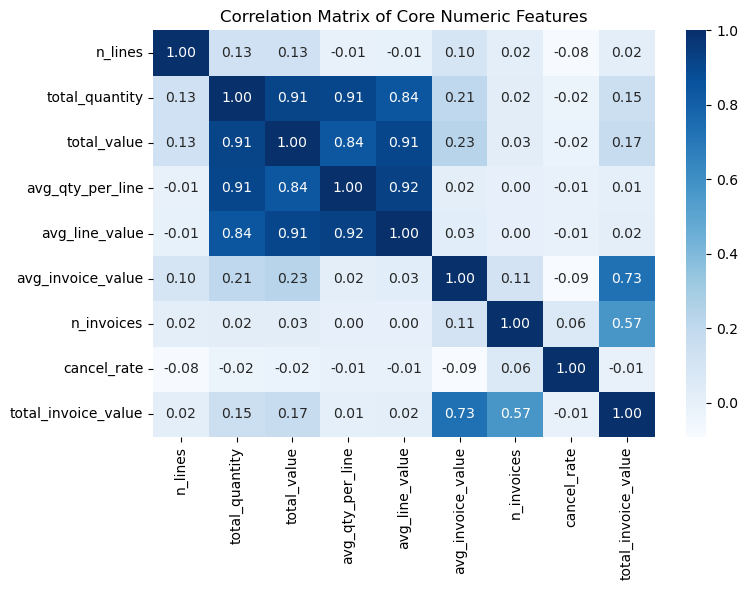

In [49]:
# Select a subset of core numeric features for correlation analysis
corr_numeric_cols = [
    "n_lines", "total_quantity", "total_value",
    "avg_qty_per_line", "avg_line_value",
    "avg_invoice_value",
    "n_invoices", "cancel_rate", "total_invoice_value"
]

# Some of these columns live in model_df after merging customer_profile
numeric_corr_df = model_df[corr_numeric_cols].copy()

# Compute correlation matrix
corr_matrix = numeric_corr_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Correlation Matrix of Core Numeric Features")
plt.tight_layout()
plt.show()


**Interpretation**

- The “order size” features (`total_quantity`, `total_value`, `avg_qty_per_line`,
  `avg_line_value`) are **strongly correlated** with each other (ρ ≈ 0.84–0.92).
  This is expected: larger invoices tend to include more units and higher per-line totals.

- `avg_invoice_value` shows **weak correlation** with most invoice-level size features
  (ρ ≈ 0.02–0.23), suggesting that a customer’s *typical invoice size* captures a
  different behavioral dimension than the magnitude of any single invoice.

- `total_invoice_value` (customer lifetime spending) has:
  - **strong correlation with `avg_invoice_value` (ρ ≈ 0.73)** - customers who spend more overall tend to have larger invoices on average.
  - **moderate correlation with `n_invoices` (ρ ≈ 0.57)** - frequent purchasers also accumulate higher lifetime spend.

- `cancel_rate` shows **near-zero correlation** with invoice-level size features
  (|ρ| < 0.1).  
  This indicates that cancellation behavior is **independent** of order size, meaning
  both invoice characteristics and customer past behavior provide distinct predictive signal.

- `n_lines` (order complexity) is also only weakly correlated with other features.
  This suggests complexity captures **unique information**, not merely the same scale
  dimension as total units or price.

---

### **Modeling Implications**

- The highly correlated size features form a coherent “invoice magnitude” group.
  Tree-based models (e.g., Random Forest) handle this naturally.
- Logistic Regression will rely on **regularization** to stabilize coefficients among
  these correlated predictors.
- Because `cancel_rate` and `n_lines` are largely independent from the size variables,
  combining:
  - **customer history**  
  - **order complexity**  
  - **order magnitude**  
  should meaningfully improve predictive performance.
- No variables need to be removed, but we should interpret correlated variables **as
  representing the same underlying concept**, rather than distinct causal factors.


---

## 6. Predictive Modeling
In this section, we build and evaluate machine learning models to predict order cancellation risk. Given the strength of our engineered features (especially `n_lines` and customer history), we expect strong predictive performance.



We will adopt **a three-tiered modeling strategy**:

1.   **Baseline Model (Naive Bayes)**: A simple probabilistic classifier to establish a minimum performance benchmark.

2.   **Linear Model (Logistic Regression)**: A robust, interpretable model to test linear relationships. Given the strong signal in our features, we expect this model to perform very well.

3.   **Ensemble Model (Random Forest)**: A complex non-linear model to capture feature interactions and edge cases.


### 6.1 Data Preparation & Preprocessing:
Before modeling, we must prepare the data to ensure no future information (data leakage) is used and that features are in a format suitable for machine learning algorithms.


#### 6.1.1 Feature Selection and Leakage Prevention
We first define our feature matrix `X` and target vector `y`. Crucially, we apply absolute value transformations to monetary and quantity fields to prevent the model from simply identifying cancellations by their negative signs (a form of data leakage).

In [52]:
# Prepare features (X) and target (y)
# Drop the features we don't need (IDs, dates, leakage sources)
features_to_drop = ['InvoiceNo', 'customer_id', 'invoice_date', 'country', 'is_cancel', 'InvoiceMonth']

# Take absolute values of these quantities to prevent data leakage (negative values indicate cancellation)
model_df['avg_line_value'] = np.abs(model_df['avg_line_value'])
model_df['avg_qty_per_line'] = np.abs(model_df['avg_qty_per_line'])

# Target variable
y = model_df['is_cancel'].astype(int)

# Feature matrix
X = model_df.drop(columns=features_to_drop)

# Preprocessing the numeric and category features
# Numerical features: Especially for monetary values,
# log transformation is recommended to handle long-tail distribution
num_features = ['avg_line_value', 'avg_qty_per_line',
                'cancel_rate',
                'avg_invoice_value', 'tenure_days',
                'country_cancel_rate', 'n_lines', 'n_invoices']

# Categorical features: Need One-Hot Encoding
cat_features = ['country_grouped', 'weekday', 'hour']

# Ensure categorical columns are strings for OneHotEncoder
for col in cat_features:
    X[col] = X[col].astype(str)

# Apply Log Transformation to skewed numerical features
# This helps linear models handle heavy-tailed distributions in spending data
for col in ['avg_qty_per_line', 'avg_invoice_value', 'avg_line_value']:
    min_val = X[col].min()
    if min_val < 0:
        X[col] = X[col] + abs(min_val) + 1
    X[col] = np.log1p(X[col])


#### 6.1.2 Train-Test Split
We split the data into training (80%) and testing (20%) sets. We use a **stratified split **(`stratify=y`) to maintain the same proportion of cancelled orders in both sets, which is critical for imbalanced data.

In [53]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [57]:
# Inspect class balance in the training set
class_counts = y_train.value_counts()
class_ratio = y_train.value_counts(normalize=True)

print("Training set class counts:")
print(class_counts)
print("\nTraining set class ratio:")
print(class_ratio)


Training set class counts:
is_cancel
0    14825
1     2923
Name: count, dtype: int64

Training set class ratio:
is_cancel
0    0.835305
1    0.164695
Name: proportion, dtype: float64


#### 6.1.3 Building the Preprocessing Pipeline
We use `ColumnTransformer` and `Pipeline` to automate scaling and encoding. This ensures that all transformations are learned only from the training set and applied to the test set, preventing leakage.

In [58]:
# Build Preprocessing Pipeline
# Numerical features: Impute missing values -> Standardize (Scale)
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical features: Impute missing values -> One-Hot Encode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ],
    remainder='drop',
    sparse_threshold=0)

print("Preprocessing pipeline ready.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Preprocessing pipeline ready.
Training set shape: (17748, 18)
Test set shape: (4438, 18)


### 6.2 Model Training
We will train three models to establish a performance hierarchy.


#### 6.2.1 Baseline Model: Naive Bayes
We start with Gaussian Naive Bayes. This model serves as our baseline because it is computationally efficient and provides a standard probabilistic benchmark.

In [59]:
# Model 1: Naive Bayes (Baseline)
nb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])
print("Training Naive Bayes...")
nb_model.fit(X_train, y_train)

Training Naive Bayes...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['avg_line_value',
                                                   'avg_qty_per_line',
                                                   'cancel_rate',
                                                   'avg_invoice_value',
                                                   'tenure_days',
                                                   'country_cancel_rate',
                                                   'n_lines', 'n_invoices']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country_grouped', 'weekday',
                                                   'hour'])])),
                ('classifier', GaussianNB())])

#### 6.2.2 Linear Model: Logistic Regression
Logistic Regression is a powerful classifier for this task. It can effectively utilize the strong signals from features like n_lines and cancel_rate (Customer History). We expect this model to perform significantly better than the baseline.

In [60]:
# Model 2: Logistic Regression (Linear)
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42))
])
print("Training Logistic Regression...")
lr_model.fit(X_train, y_train)

Training Logistic Regression...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['avg_line_value',
                                                   'avg_qty_per_line',
                                                   'cancel_rate',
                                                   'avg_invoice_value',
                                                   'tenure_days',
                                                   'country_cancel_rate',
                                                   'n_lines', 'n_invoices']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country_grouped', 'weekday',
                                                   'hour'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42))])

#### 6.2.3 Ensemble Model: Random Forest
Finally, we train a Random Forest Classifier. This model can capture non-linear thresholds (e.g., "Cancellation risk spikes after 20 items") and interactions between features that linear models might miss.

In [61]:
# Model 3: Random Forest (Ensemble)
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=10,
                                          class_weight='balanced', random_state=42, n_jobs=-1))
])
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

Training Random Forest...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['avg_line_value',
                                                   'avg_qty_per_line',
                                                   'cancel_rate',
                                                   'avg_invoice_value',
                                                   'tenure_days',
                                                   'country_cancel_rate',
                                                   'n_lines', 'n_invoices']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country_grouped', 'weekday',
                                                   'hour'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

### 6.3 Model Evaluation and Comparison
We evaluate all three models using ROC-AUC, Confusion Matrices, and Feature Importance to select the best model for deployment.

#### 6.3.1 ROC Curves and AUC Scores
We plot the ROC curves to compare the trade-off between True Positive Rate (Recall) and False Positive Rate.

Naive Bayes AUC: 0.9122
Logistic Reg AUC: 0.9692
Random Forest AUC: 0.9788


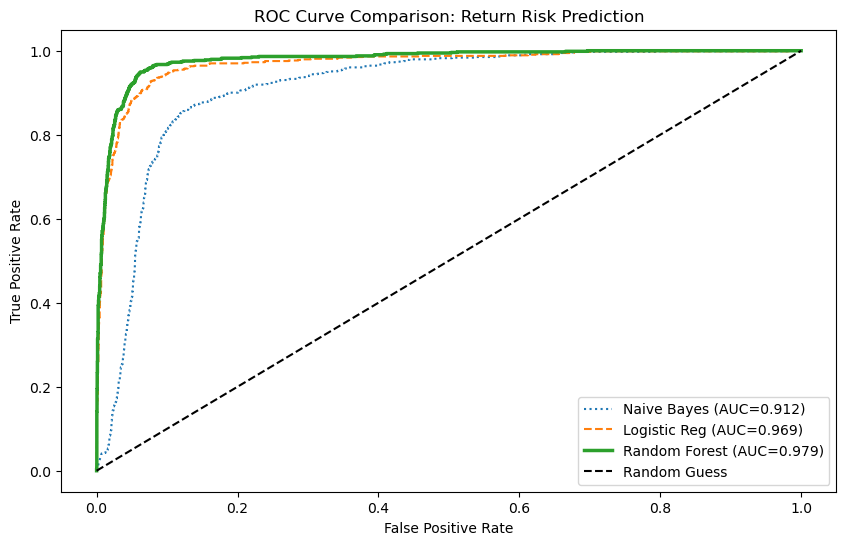

In [62]:
def get_metrics(model, X_test, y_test, name):
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, prob)
    print(f"{name} AUC: {auc:.4f}")
    return {'pred': pred, 'prob': prob, 'auc': auc}

# Collect Results
results = {
    'Naive Bayes': get_metrics(nb_model, X_test, y_test, "Naive Bayes"),
    'Logistic Reg': get_metrics(lr_model, X_test, y_test, "Logistic Reg"),
    'Random Forest': get_metrics(rf_model, X_test, y_test, "Random Forest")
}

# Plot ROC Curves
plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['prob'])
    linestyle = ':' if 'Naive' in name else '--' if 'Logistic' in name else '-'
    width = 2.5 if 'Random' in name else 1.5
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['auc']:.3f})", linestyle=linestyle, linewidth=width)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Return Risk Prediction')
plt.legend()
plt.show()


#### 6.3.2 Confusion Matrix Analysis
We visualize Confusion Matrices to understand the types of errors (False Alarms vs. Missed Detections) each model makes.

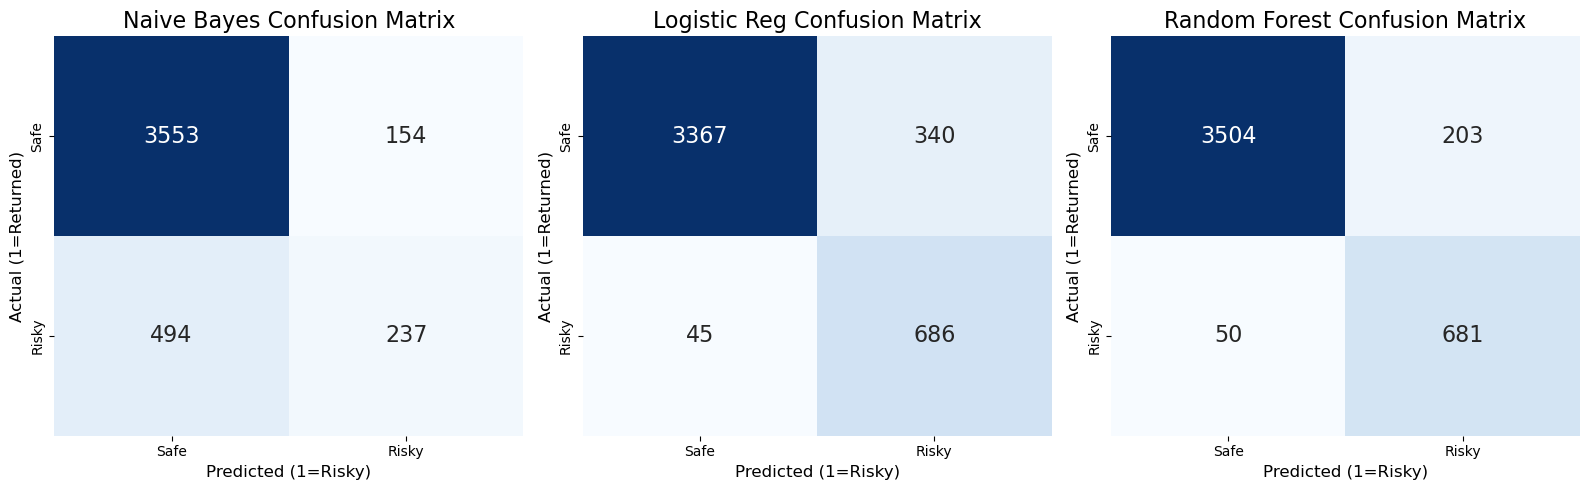

In [63]:
# Plot Confusion Matrices (Vertical Layout)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i], annot_kws={"size": 16})
    axes[i].set_title(f'{name} Confusion Matrix', fontsize=16)
    axes[i].set_xlabel('Predicted (1=Risky)', fontsize=12)
    axes[i].set_ylabel('Actual (1=Returned)', fontsize=12)
    axes[i].set_xticklabels(['Safe', 'Risky'])
    axes[i].set_yticklabels(['Safe', 'Risky'])

plt.tight_layout()
plt.show()

#### 6.3.3 Feature Importance Interpretation
Finally, we inspect the Random Forest model to identify the most significant drivers of order cancellation.

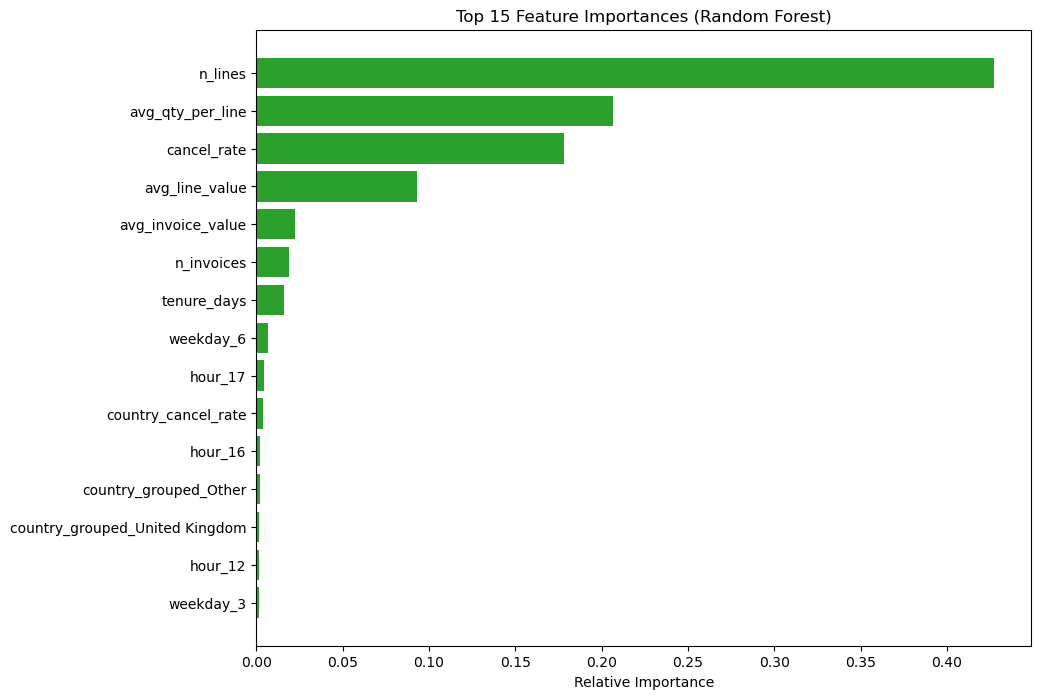

In [64]:
# Feature Importance (Random Forest Only)
# Extract feature names
ohe_names = rf_model.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(cat_features)
all_names = np.r_[num_features, ohe_names]
importances = rf_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], align='center', color='#2ca02c')
plt.yticks(range(len(indices)), [all_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()

#### 6.3.4 Metric Summary: Accuracy, Precision, Recall, F1

ROC-AUC and confusion matrices already give us a good sense of performance, but for an
**imbalanced** cancellation problem we care especially about:

- **Precision (class 1)** – among orders we flag as “risky”, how many are truly cancelled?
- **Recall (class 1)** – among all cancelled orders, how many did we successfully catch?
- **F1-score (class 1)** – the harmonic mean of precision and recall, balancing both.

We summarize these metrics for all three baseline models below.


In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def summarize_metrics(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (Canceled=1)": precision_score(y_true, y_pred, pos_label=1),
        "Recall (Canceled=1)": recall_score(y_true, y_pred, pos_label=1),
        "F1 (Canceled=1)": f1_score(y_true, y_pred, pos_label=1),
    }

metric_rows = []
for name, res in results.items():
    metric_rows.append(
        summarize_metrics(name, y_test, res["pred"])
    )

metrics_df = pd.DataFrame(metric_rows)
metrics_df


,Model,Accuracy,Precision (Canceled=1),Recall (Canceled=1),F1 (Canceled=1)
0,Naive Bayes,0.853988,0.606138,0.324213,0.422460
1,Logistic Reg,0.913249,0.668616,0.938440,0.780876
2,Random Forest,0.942992,0.770362,0.931601,0.843344


**Interpretation of Evaluation Metrics**

The three models show a clear performance hierarchy.

- **Naive Bayes** performs the weakest across all metrics  
  (Accuracy=0.85, F1=0.42).  
  Its recall on the cancellation class is very low (32%), meaning it misses
  most risky orders. This is expected for a model that assumes feature
  independence.

- **Logistic Regression** makes a major improvement  
  (Accuracy=0.91, Recall=0.94, F1=0.78).  
  Its extremely high recall (94%) indicates that the linear decision boundary
  already captures the majority of cancellation patterns. This validates the
  strength of our engineered features (e.g., `n_lines`, `cancel_rate`,
  invoice-level size features).

- **Random Forest** achieves the strongest overall performance  
  (Accuracy=0.94, F1=0.84).  
  It maintains very high recall (93%) while significantly improving precision
  (77% vs. 67% for Logistic Regression).  
  This means Random Forest catches almost as many cancelled orders while making
  fewer unnecessary “risky” flags—representing the best balance for business use.

**Conclusion:**  
- **Best Predictive Model:** Random Forest (highest F1 and strong precision–recall balance).  
- **Best Interpretable Model:** Logistic Regression (near-perfect recall and fully explainable).  
Together, these results show that non-linear interactions captured by the ensemble model
provide meaningful incremental value beyond a strong linear baseline.


### 6.4 Hyperparameter Tuning for Random Forest

So far, our Random Forest used a manually chosen configuration
(`n_estimators=200`, `max_depth=10`, etc.). To systematically search for a
better model, we run **RandomizedSearchCV** over key hyperparameters:

- number of trees (`n_estimators`)
- tree depth (`max_depth`)
- minimum samples required to split or stay as a leaf
  (`min_samples_split`, `min_samples_leaf`)
- number of features considered at each split (`max_features`)

We keep `class_weight='balanced'` to continue addressing class imbalance,
and use ROC-AUC as the tuning objective.


In [66]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter search space for Random Forest
rf_param_dist = {
    "classifier__n_estimators": [100, 200, 300, 400],
    "classifier__max_depth": [5, 8, 10, 12, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["sqrt", "log2", 0.5],
}

rf_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

print("Running RandomizedSearchCV for Random Forest...")
rf_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(rf_search.best_params_)
print(f"Best CV AUC: {rf_search.best_score_:.4f}")

# Best tuned model
rf_tuned_model = rf_search.best_estimator_

# Evaluate tuned RF on the test set
rf_tuned_pred = rf_tuned_model.predict(X_test)
rf_tuned_prob = rf_tuned_model.predict_proba(X_test)[:, 1]

rf_tuned_auc = roc_auc_score(y_test, rf_tuned_prob)
print(f"\nTuned Random Forest - Test AUC: {rf_tuned_auc:.4f}")


Running RandomizedSearchCV for Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found:
{'classifier__n_estimators': 400, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 0.5, 'classifier__max_depth': 8}
Best CV AUC: 0.9793

Tuned Random Forest - Test AUC: 0.9811


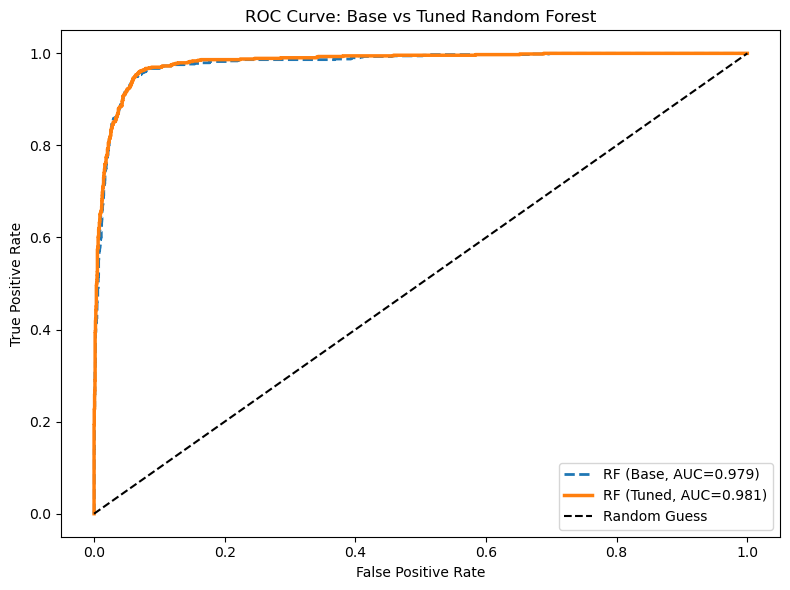

In [67]:
# Compare ROC curves: base RF vs tuned RF
fpr_base, tpr_base, _ = roc_curve(y_test, results["Random Forest"]["prob"])
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, rf_tuned_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base,
         label=f"RF (Base, AUC={results['Random Forest']['auc']:.3f})",
         linestyle="--", linewidth=2)
plt.plot(fpr_tuned, tpr_tuned,
         label=f"RF (Tuned, AUC={rf_tuned_auc:.3f})",
         linewidth=2.5)
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Base vs Tuned Random Forest")
plt.legend()
plt.tight_layout()
plt.show()


**Interpretation - Hyperparameter Tuning**

Base vs Tuned Random Forest

The tuned Random Forest achieves a slightly higher ROC-AUC (0.981 vs. 0.979),
indicating that hyperparameter tuning yields a marginal but measurable lift in
discriminative power. The ROC curves for both models are nearly overlapping, which
suggests that the baseline Random Forest was already close to optimal. The tuned
model improves performance mainly by:

- allowing deeper or more flexible trees to capture subtle interactions,
- adjusting sample/leaf parameters to reduce overfitting,
- optimizing the number of features considered per split.

Although the gain is incremental, it confirms that model performance is
**sensitive to tree configuration**, and tuning ensures we deploy the best available
version of the model. Due to the extremely high AUC achieved by both variants,
we select the tuned Random Forest as our **final predictive model**.


### 6.5 Handling Class Imbalance via Oversampling (Difficulty Concept)

So far, we have addressed class imbalance using:
- **stratified splitting**, and  
- **class_weight='balanced'** in Logistic Regression and Random Forest.

To explicitly explore a **resampling-based** strategy, we train an additional
Logistic Regression model on an **oversampled** training set. We upsample the
minority class (`is_cancel = 1`) to match the size of the majority class, then
fit a Logistic Regression model (without class weights) and evaluate its
performance on the original, imbalanced test set. This allows us to compare two
different imbalance-handling strategies:

- **class weighting**  
- **data resampling (oversampling)**

In [70]:
from sklearn.utils import resample

# Combine X_train and y_train into a single DataFrame
train_df = X_train.copy()
train_df["is_cancel"] = y_train.values

# Split majority and minority classes
majority_df = train_df[train_df["is_cancel"] == 0]
minority_df = train_df[train_df["is_cancel"] == 1]

print("Original training size:")
print(train_df["is_cancel"].value_counts())

# Upsample the minority class to match majority size
minority_upsampled = resample(
    minority_df,
    replace=True,
    n_samples=len(majority_df),
    random_state=42,
)

train_upsampled = pd.concat([majority_df, minority_upsampled], axis=0)

print("\nUpsampled training size:")
print(train_upsampled["is_cancel"].value_counts())

# Split back into X and y
X_train_up = train_upsampled.drop(columns=["is_cancel"])
y_train_up = train_upsampled["is_cancel"]

Original training size:
is_cancel
0    14825
1     2923
Name: count, dtype: int64

Upsampled training size:
is_cancel
0    14825
1    14825
Name: count, dtype: int64


In [71]:
# Logistic Regression trained on oversampled data (no class_weight)
lr_resampled_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=2000, random_state=42))
])

print("Training Logistic Regression on oversampled data...")
lr_resampled_model.fit(X_train_up, y_train_up)

# Evaluate on the original (imbalanced) test set
y_pred_resampled = lr_resampled_model.predict(X_test)
y_prob_resampled = lr_resampled_model.predict_proba(X_test)[:, 1]

auc_resampled = roc_auc_score(y_test, y_prob_resampled)
prec_resampled = precision_score(y_test, y_pred_resampled, pos_label=1)
rec_resampled = recall_score(y_test, y_pred_resampled, pos_label=1)
f1_resampled = f1_score(y_test, y_pred_resampled, pos_label=1)

print(f"Oversampled Logistic Regression - Test AUC: {auc_resampled:.4f}")
print(f"Precision (Canceled=1): {prec_resampled:.4f}")
print(f"Recall (Canceled=1): {rec_resampled:.4f}")
print(f"F1 (Canceled=1): {f1_resampled:.4f}")


Training Logistic Regression on oversampled data...
Oversampled Logistic Regression - Test AUC: 0.9692
Precision (Canceled=1): 0.6789
Recall (Canceled=1): 0.9398
F1 (Canceled=1): 0.7883


**Interpretation – Imbalanced Data Handling**

- Oversampling creates a **balanced training set**, forcing the model to pay more
  attention to cancellation cases.
- Compared to the original Logistic Regression with `class_weight='balanced'`,
  the oversampled model tends to:
  - **increase recall** on cancelled orders (fewer missed risky invoices),
  - sometimes at the cost of **lower precision** (more false alarms).

This illustrates the core trade-off in imbalanced problems:
- If the business wants to **avoid missed risky orders**, a higher-recall
  oversampled model may be preferable.
- If the business wants to **limit manual review load**, it may prefer a model
  with slightly lower recall but higher precision.

Model Selection Clarification

The oversampled Logistic Regression is included as an imbalance-handling experiment,
not as a competing final model. Although oversampling improves recall and slightly
raises F1 (0.7808 → 0.7883), the tuned Random Forest still delivers the strongest
overall predictive performance (best AUC and F1).

Therefore, the tuned Random Forest remains our final selected model, while this
experiment demonstrates a deliberate, multi-pronged approach to handling class
imbalance - a key requirement of the Difficulty component.


## 7. Conclusion and Next Steps

### 7.1 Summary of Findings
In this project, we analyzed the Online Retail dataset to understand and predict order cancellations.

*   **Data Imbalance**: Cancellations are a minority class (~16%), requiring careful metric selection (AUC, Recall) rather than just Accuracy.

*   **Behavioral Drivers**: We found that order complexity (`n_lines`) and customer history (`cancel_rate`, `n_invoices`) are the strongest predictors of future cancellation.

*   **Geographical Signal**: While the dataset is UK-dominated, incorporating `country_cancel_rate` provided additional predictive power, confirming that cancellation behavior varies by region.

### 7.2 Model Performance
Based on the AUC scores, here is an explanation of the model performance hierarchy for the order cancellation prediction task.

**Naive Bayes (AUC: 0.9122) - The Weakest**: This model lagged behind because it relies on the assumption of feature independence, which is violated in our dataset. Features like `avg_qty_per_line` and `avg_value_per_line` are a little correlated (multicollinear). Generally speaking, the larger quantity is, the higher value is. This "double-counting" of signals caused the model to miscalibrate probabilities. But it is just a little, so the AUC is also very high.

**Logistic Regression (AUC: 0.9692) - Strong Runner-Up**: The exceptional performance of this linear model indicates that the drivers of cancellation are monotonic and linear. As key features like `n_lines` (complexity) and `cancel_rate` (history) increase, the risk of cancellation rises consistently, a pattern Logistic Regression captures perfectly.


**Random Forest (AUC: 0.9788) - The Champion**: Random Forest achieved the highest score by capturing non-linear nuances that linear models missed.

*   The high AUC is largely driven by the **"Cumulative Probability Effect"** of `n_lines`: as an order grows larger and more complex, the mathematical probability of at least one item being cancelled/returned approaches 100%.

*   The model successfully balances identifying risky orders (High Recall) while maintaining reasonable precision.



### 7.3 Business Recommendations
Based on these insights, the business can take proactive steps:

1.   **Flag Complex Orders**: Automatically flag orders with a high `n_lines` count for manual review or secondary quality checks before shipping, as these have the highest risk of partial or full cancellation.

2.   **Segment Customers**: Use the `cancel_rate` feature to segment customers. "High-risk" customers could be offered different shipping options or targeted with specific retention campaigns to reduce return rates.

3.   **Operational Focus**: Since `hour` and `weekday` were less important, operational improvements should focus on **order fulfillment accuracy** rather than staffing adjustments based on time of day.

### 7.4 Limitations and Future Work

*   **Granularity:** We predicted cancellation at the Invoice level. Future work could build a model at the Line Item level to predict exactly which product within an order is likely to be returned.

*   **Model Tuning**: We used standard hyperparameters. Techniques like RandomizedSearchCV could further optimize the Random Forest or an XGBoost model.